In [1]:
# This file is the Jupyter notebook for the Machine Learning 1 Lab 1
# Author: Tom Pengilly
# Group Members: Tom Pengilly, Quynh Chao, Michael Weatherford, Anish Patel
# Date: 9/3/2020


Dataset Source: https://www.kaggle.com/rmjacobsen/property-listings-for-5-south-american-countries?select=co_properties.csv

# Business Purpose
The South American Real Estate Listings is a super data set that aggregated property listings from five separate data sets published by Kaggle. This information contains a wide variety of real estate properties and may be used by corporate developers, individual investors, retirees and expatriates doing their due diligence in considering potential acquisitions, investment or living arrangements. 

The original data sets contain property listings from five countries: Argentina, Columbia, Ecuador, Peru, and Uruguay collected by Prosperati Data, the data division of the Latin American search company Prosperati. For purposes of comparability and analysis, we aggregated the five databases resulting in a super data set that has over 2 million rows with 26 attributes and took multiple steps to wrangle the combined data set so as to have a clean final data set for exploratory data analysis.

We will be using regression analysis to predict pricing for real estate properties that are listed for sale in select South American countries. We will split the data into training and test sets using 10-fold cross-validation, and measure the performance of our model based on the RMSE. The choice of RMSE as the model criterion is due to the wide variation in property prices, and the desire to minimize large errors as much as possible. The analysis can be considered successful if we can create a model that sufficiently minimizes the RMSE, allowing our users to use the predicted fair market value in considering whether to purchase a property.

We will also be using classification to predict whether a property's price is low, average, or high for a given property type. The effectiveness of this model will be judged using the accuracy rate. This model will be considered successful if the  accuracy is above customer thresholds. This will allow customers to take advantage of price discrepancies between listing price and fair market value to make the best investment decisions.

# Data Understanding: 
The following section includes the code used to for data wrangling, missing/outlier handling, visualization, attribute relations, and interesting findings.

## 1. Data Meaning
The data set contains listings of properties from February 2019 through March 2020.  Some listings may still be live at the date of this report.  The properties listed may not be unique since this data set contains transactions.  Therefore, it is possible for there to be multiple sequential listings for the same property, if that property was bought and sold, or unlisted and relisted during the same time periods covered by the data set.  We did not remove multiple listings for the same property because these may reflect multiple price changes.

id: property id number. Not unique for all observations.
ad_type: type of listing.
    Propiedad (Property)
    Desarrollo/Proyecto (Development/Project)
start_date: listing date
end_date: listing cancellation date
created_on: date of registration of FIRST version of listing for a given property
lat: latitude
lon: longitude
l1: administrative level 1: Country
l2 - Administrative Level 2: Usually the province of the property.
l3 - Administrative Level 3: Usually the city of the property.
l4 - Administrative Level 4: Usually the neighbourhood of the property.
l5 – Administrative Level 5: Subregion of neighborhood of property
l6: Any??????
rooms: total number of rooms
bedrooms: number of bedrooms
bathrooms: number of bathrooms
surface_total: total area in  m².
surface_covered - Area covered in m².
price - Price published in the listing.
currency - Currency of published price.
price_period - Payment periods:
    Diario (Daily)
    Semanal (Weekly)
    Mensual (Monthly)
title - Title of the listing (These are in Spanish).
description - Description of the listing (listing body) (In Spanish).
property_type: type of property
    Casa (House)
    Deparamento (Apartment)
    Lote (Lot)
    PH (Horizontal Property: Condominium or other property where owners seperately own portions of the property and collectively own portions of the property)
    Oficina (Office)
    Otro (Other)
    Local comercial (Shop)
    Cochera (Garage)
    Deposito (Warehouse)
    Parqueadero (Parking Lot)
    Finca (Farm)
    Casa de campo (Cottage)
operation_type: Type of listing
    Venta (Sale)
    Alquiler (Rent)
    Alquiler temporal (Temporary rental)

## Data Wrangling: 
The data wrangling code used to concatenate, clean, and convert our data is shown below.  The first section deals with creating our final dataset for use in our analysis.

There were multiple steps taken to build our South American Real Estate Listing data set used for analysis.

1. Aggregation of five Prosperati datasets from Kaggle
2. Reformat attributes into ordinal, continuous, and categorical in order to explore/change them more easily
3. Clean the data for inconsistent values such as: remove listings that have not yet expired (end date 9999-12-31), that have no price or currency,  removing factor levels that are not of interest, and converting prices to USD using exchange rate histories. Exchange rate data source: https://www.investing.com/currencies/. The exchange rate chosen corresponded to the end-date of the listing.
4. Missing/invalid data were omitted. Given the large number of records we have from the aggregated data set of 2M, the omission of rows with invalid or missing data values, excluding numeric variables, would not negatively impact our EDA. 
5. Thousands of duplicate observations were removed.
6. The dataset was filtered to exclude properties for rent, since the price is listed in different units (dollars/month).
7. The final cleaned data set had 25 attributes and 694,993 rows of real estate listings for sale (operation_type == Venta) in five South American countries (l1 = Argentina, Brazil, Uruguay, Ecuador, and Peru). 


In [1]:
# Import the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import set_option
set_option('display.max_columns',400)
from pandas_profiling import ProfileReport
import copy as cp
import os
import glob
import matplotlib as mplt
import re
import datetime
from scipy.stats import ks_2samp, ttest_ind
import seaborn as sns
from IPython.display import Image
# from pandas.tools.plotting import scatter_matrix
# from pandas.tools.plotting import parallel_coordinates

The following two cells concatenate all csv files into one dataset and recast all features to the appropriate data type.

In [2]:
# Concatenate all data files and create the combined dataset
os.chdir('C:\\Users\\Tpeng\\OneDrive\\Documents\\SMU\\Term 3\\Machine Learning\\Lab1\\DatasetAndPreprocessing')
path = os.getcwd()
print(path)

#Read and Concat all data files
all_files = glob.glob(path + "/*.csv")
property_data = []

# Create the combined dataset

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    property_data.append(df)

combineddf = pd.concat(property_data, axis=0, ignore_index=True, sort = False)

C:\Users\Tpeng\OneDrive\Documents\SMU\Term 3\Machine Learning\Lab1\DatasetAndPreprocessing


In [3]:
# Reformat attributes in order to explore/change them more easily
# Split variables into ordinal, continuous and categorical
ordinal_vars = ['rooms', 'bedrooms', 'bathrooms' ]
continuous_vars = ['lat', 'lon', 'surface_total', 'surface_covered', 'price']
categorical_vars = ['ad_type', 'l1', 'l2', 'l3', 'l4', 'l5', 'l6', 'currency', 'price_period', 'property_type', 'operation_type']
string_vars = ['id', 'title', 'description']
time_vars = ['start_date', 'end_date', 'created_on']

# Create a dataframe with  missing values as -1 or 0 (this is done to allow the datatypes to be changed)
# dates of 9999-12-31 are replaced w/ 1970-01-01 since this value is used to determine exchange rates and throws an error
combineddf[ordinal_vars] = combineddf[ordinal_vars].replace(to_replace = np.nan, value = -1)
combineddf[time_vars] = combineddf[time_vars].replace(to_replace = "9999-12-31", value = 0)

# Change data types
combineddf[ordinal_vars] = combineddf[ordinal_vars].astype(np.int64)
combineddf[continuous_vars] = combineddf[continuous_vars].astype(np.float64)
combineddf[categorical_vars] = combineddf[categorical_vars].astype('category')
combineddf[string_vars] = combineddf[string_vars].astype(str)
combineddf[time_vars] = pd.to_datetime(combineddf[time_vars].stack(), format = "%Y-%m-%d").unstack()

# Combine equivalent categorical levels
combineddf = combineddf.replace(to_replace = 'Cochera', value = 'Garaje')
combineddf = combineddf.replace(to_replace = 'Apartamento', value = 'Departamento')

In [7]:
# Export to file for convenience
combineddf.to_csv('C:\\Users\\Tpeng\\OneDrive\\Documents\\SMU\\Term 3\\Machine Learning\\Lab1\\DatasetAndPreprocessing\\Combined data\\Combined_Dataset.csv', sep = ',')

The following cell bypasses the above concatenation procedure to load the same dataset and again recast the features.

In [2]:
# # Read in the combined dataset (to avoid running code repeatedly)
# combineddf = pd.read_csv('C:\\Users\\Tpeng\\OneDrive\\Documents\\SMU\\Term 3\\Machine Learning\\Lab1\\DatasetAndPreprocessing\\Combined data\\Combined_Dataset.csv', sep = ',', header = 0)

# # Reformat attributes in order to explore/change them more easily
# # Split variables into ordinal, continuous and categorical
# ordinal_vars = ['rooms', 'bedrooms', 'bathrooms' ]
# continuous_vars = ['lat', 'lon', 'surface_total', 'surface_covered', 'price']
# categorical_vars = ['ad_type', 'l1', 'l2', 'l3', 'l4', 'l5', 'l6', 'currency', 'price_period', 'property_type', 'operation_type']
# string_vars = ['id', 'title', 'description']
# time_vars = ['start_date', 'end_date', 'created_on']

# # Create a dataframe with  missing values as -1 or 0 (this is done to allow the datatypes to be changed)
# # dates of 9999-12-31 have already been replaced w/ 1970-01-01 since this value is used to determine exchange rates and throws an error
# combineddf[ordinal_vars] = combineddf[ordinal_vars].replace(to_replace = np.nan, value = -1)
# combineddf[time_vars] = combineddf[time_vars].replace(to_replace = "9999-12-31", value = 0)

# # Change data types
# combineddf[ordinal_vars] = combineddf[ordinal_vars].astype(np.int64)
# combineddf[continuous_vars] = combineddf[continuous_vars].astype(np.float64)
# combineddf[categorical_vars] = combineddf[categorical_vars].astype('category')
# combineddf[string_vars] = combineddf[string_vars].astype(str)

# # Time variables left as strings for the time being. This is to allow analysis of incorrect date times
# #combineddf[time_vars] = pd.to_datetime(combineddf[time_vars].stack(), format = '%Y-%m-%d', unit = 'D').unstack()

C:\Users\Tpeng\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (0,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# Display dataset 
combineddf

,id,ad_type,start_date,end_date,created_on,lat,lon,l1,l2,l3,l4,l5,l6,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,currency,price_period,title,description,property_type,operation_type
0,7LoZFkSIPOTox0r32ck42Q==,Propiedad,2019-09-15,2019-10-26,2019-09-15,-26.815439,-65.312393,Argentina,Tucumán,Yerba Buena,NaN,NaN,NaN,-1,-1,-1,NaN,NaN,NaN,NaN,Mensual,Terreno - Yerba Buena,Accesos pavimentados.<br>Red subterránea de ag...,Lote,Venta
1,QsZD4OxZInNd5po5LQDRmg==,Propiedad,2019-09-15,1970-01-01,2019-09-15,-26.839469,-65.212790,Argentina,Tucumán,NaN,NaN,NaN,NaN,-1,-1,1,55.0,41.0,NaN,NaN,Mensual,Departamento - Capital,Detalles constructivos:<br><br>Pisos de porcel...,Departamento,Venta
2,qDtysoUgbnHLp0W9We+8fg==,Propiedad,2019-09-15,2019-09-25,2019-09-15,-31.424820,-64.181225,Argentina,Córdoba,Córdoba,Nueva Córdoba,NaN,NaN,2,-1,1,45.0,45.0,NaN,NaN,Mensual,1 DORMITORIO | San Lorenzo al 400,Alquiler temporario de Departamento 1 DORMITOR...,Departamento,Alquiler temporal
3,olj51zV0HFurmaZ78U0ssg==,Propiedad,2019-09-15,2019-09-25,2019-09-15,-31.421242,-64.190798,Argentina,Córdoba,Córdoba,Centro,NaN,NaN,2,-1,1,48.0,48.0,NaN,NaN,Mensual,1 DORMITORIO | M. T. de Alvear al 500,Alquiler temporario de Departamento 1 DORMITOR...,Departamento,Alquiler temporal
4,OcS1SAA5oAzjZ3Mzg3XHyg==,Propiedad,2019-09-15,2019-09-25,2019-09-15,-31.426064,-64.180042,Argentina,Córdoba,Córdoba,Nueva Córdoba,NaN,NaN,2,-1,1,45.0,45.0,NaN,NaN,Mensual,1 DORMITORIO | Av. Poeta Lugones al 200,Alquiler temporario de Departamento 1 DORMITOR...,Departamento,Alquiler temporal
5,vY1UjrDt8jFIGPtJfdpNZQ==,Propiedad,2019-09-15,2019-09-25,2019-09-15,-31.429089,-64.189291,Argentina,Córdoba,Córdoba,Nueva Córdoba,NaN,NaN,1,-1,1,45.0,45.0,NaN,NaN,Mensual,Departamento - Nueva Cordoba,Alquiler temporario de Departamento 1 DORMITOR...,Departamento,Alquiler temporal
6,D1KQkn+XsaOHRKVUuQRtpg==,Propiedad,2019-09-15,2019-09-25,2019-09-15,-31.418640,-64.188257,Argentina,Córdoba,Córdoba,Centro,NaN,NaN,2,-1,1,45.0,45.0,NaN,NaN,Mensual,1 DORMITORIO | Av. Vélez Sarsfield al 200,Alquiler temporario de Departamento 1 DORMITOR...,Departamento,Alquiler temporal
7,2yVnYhBoYRQ5r/mfQ32Mwg==,Propiedad,2019-09-15,2019-09-25,2019-09-15,-31.425732,-64.180824,Argentina,Córdoba,Córdoba,Nueva Córdoba,NaN,NaN,1,-1,1,40.0,40.0,NaN,NaN,Mensual,Departamento - Nueva Cordoba,Alquiler temporario de Departamento 1 DORMITOR...,Departamento,Alquiler temporal
8,t0kNTwjTWOdat8Z87X7QLw==,Propiedad,2019-09-15,2019-09-25,2019-09-15,-31.423450,-64.184201,Argentina,Córdoba,Córdoba,Nueva Córdoba,NaN,NaN,2,-1,-1,55.0,55.0,NaN,NaN,Mensual,1 DORMITORIO | Ituzaingó al 500,Alquiler temporario de Departamento 1 DORMITOR...,Departamento,Alquiler temporal
9,fY4sOgwvFSS5Qz2M66X7/A==,Propiedad,2019-09-15,2019-09-25,2019-09-15,-31.423823,-64.181516,Argentina,Córdoba,Córdoba,Nueva Córdoba,NaN,NaN,2,-1,1,44.0,44.0,NaN,NaN,Mensual,1 DORMITORIO | Obispo Salguero al 500,Alquiler temporario de Departamento 1 DORMITOR...,Departamento,Alquiler temporal


In [5]:
# Display data information
combineddf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2281685 entries, 0 to 2281684
Data columns (total 25 columns):
id                 object
ad_type            object
start_date         datetime64[ns]
end_date           datetime64[ns]
created_on         datetime64[ns]
lat                float64
lon                float64
l1                 object
l2                 object
l3                 object
l4                 object
l5                 object
l6                 object
rooms              int64
bedrooms           int64
bathrooms          int64
surface_total      float64
surface_covered    float64
price              float64
currency           object
price_period       object
title              object
description        object
property_type      category
operation_type     object
dtypes: category(1), datetime64[ns](3), float64(5), int64(3), object(13)
memory usage: 420.0+ MB


## 2. Verify data quality.
The initial data has 25 variables (17 categorical and 8 continuous) with over 2 million observations.  There were thousands of duplicate observations and millions of missing data points.  Further investigation of the data revealed that most of the missing values were coming from the l4, l5, l6, and price period variables.  L4, L5, L6 are the administrative levels that indicate Subregion, Neighborhood, and smaller subdivisions, while price period indicates the frequency at which payments are made.  Since these variables were missing in the majority of observations and could not be reasonably imputed, they were removed from the data set.  It is expected that their removal will not significantly impact the performance of our price prediction model. 

In addition to these rooms, bedrooms, bathrooms, lat, lon, surface_covered, and surface_total had some missing values, but these were not removed since they can be imputed. The following analysis explores missing data and possible imputation methods.

In [6]:
combineddf.describe()

,lat,lon,rooms,bedrooms,bathrooms,surface_total,surface_covered,price
count,1.953595e+06,1.952582e+06,2.281685e+06,2.281685e+06,2.281685e+06,1.131504e+06,9.734290e+05,2.218516e+06
mean,-1.416712e+01,-6.809439e+01,6.114472e-01,4.162564e-01,1.565249e+00,7.065226e+02,4.045950e+03,2.281469e+08
std,1.947222e+01,8.516002e+00,2.257139e+00,5.379730e+00,1.798455e+00,5.989372e+03,1.688760e+06,1.682844e+09
min,-5.497534e+01,-1.800000e+02,-1.000000e+00,-1.300000e+01,-1.000000e+00,-2.000000e+02,-1.700000e+02,0.000000e+00
25%,-3.459804e+01,-7.557130e+01,-1.000000e+00,-1.000000e+00,1.000000e+00,6.000000e+01,5.300000e+01,8.000000e+04
50%,-1.205826e+01,-7.313167e+01,-1.000000e+00,-1.000000e+00,2.000000e+00,1.040000e+02,8.700000e+01,3.950000e+05
75%,4.734000e+00,-5.847195e+01,2.000000e+00,2.000000e+00,2.000000e+00,2.500000e+02,1.730000e+02,1.320000e+08
max,8.505113e+01,7.539368e+01,4.000000e+01,6.820000e+03,2.000000e+01,5.000000e+05,1.419500e+09,8.500000e+11


The above shows that some observations have negative values for rooms, bedrooms, bathrooms, surface_total, and surface_covered. These will be corrected later. In addition to this, some observations have large bedroom counts (6820). These observations will be removed since they are likely mistakes.

In [7]:
# Check for missing values
print(combineddf.isna().sum())

# Print the number of incorrect dates
print('Number of end dates equal to 9999-12-31: ', len(combineddf[combineddf.end_date == "1970-01-01"]))
print('Number of start dates equal to 9999-12-31: ', len(combineddf[combineddf.start_date == "1970-01-01"]))
print('Number of created on dates equal to 9999-12-31: ', len(combineddf[combineddf.created_on == "1970-01-01"]))

id                       0
ad_type                  0
start_date               0
end_date                 0
created_on               0
lat                 328090
lon                 329103
l1                       0
l2                       0
l3                  162579
l4                 1503480
l5                 2046799
l6                 2223283
rooms                    0
bedrooms                 0
bathrooms                0
surface_total      1150181
surface_covered    1308256
price                63169
currency             71034
price_period       1732068
title                    0
description              0
property_type            0
operation_type           0
dtype: int64
Number of end dates equal to 9999-12-31:  558224
Number of start dates equal to 9999-12-31:  0
Number of created on dates equal to 9999-12-31:  0


There are 558,224 observations with incorrect end dates with values of 9999-12-31. These are likely open listings that have not yet been purchased.  This would explain why only end_date has the incorrect values and not start_date or created_on.  These values will be kept since they are still valid postings.  The observations with missing start, end, and created on dates, as well as missing price or currency, will be removed since this is used in the currency conversion process later.  Observations with missing l1 and l2 attributes will also be deleted since these are used for the creation of a price classification variable later.

There are hundreds of thousands of missing latitude and longitude variables.  The observations will be kept since the latitude and longitude variable can help with plotting, but don't necessarily convey additional information compared to the administrative subdivision variables (l1, l2, l3, l4, l5, l6).  If needed, the administrative subdivisions can be used to impute rough geographical coordinates for plotting purposes later.

Millions of observations are missing the l4, l5, and l6 administrative division attributes, as well as the surface total and surface covered attributes. These will be explored further below.

The price period (payment frequency) attribute also has millions of missing values. This variable is thought to be insignificant with regard to property pricing and will be excluded. Observations with missing property_type values will be discarded, since this is thought to have a large impact on the property value estimation.  Observations with missing operation type (rental or sale) will also be excluded since this will have a large impact on the price of the listing (rental properties have price listed on a per month basis).

In [8]:
# Print the percentage of missing values by country
print('Percentage of missing values for Argentina:\n', combineddf[combineddf.l1 == 'Argentina'].isna().sum()/len(combineddf[combineddf.l1 == 'Argentina']), '\n')
print('Percentage of missing values for Peru:\n', combineddf[combineddf.l1 == 'Perú'].isna().sum()/len(combineddf[combineddf.l1 == 'Perú']), '\n')
print('Percentage of missing values for Ecuador:\n', combineddf[combineddf.l1 == 'Ecuador'].isna().sum()/len(combineddf[combineddf.l1 == 'Ecuador']))
print('Percentage of missing values for Uruguay:\n', combineddf[combineddf.l1 == 'Uruguay'].isna().sum()/len(combineddf[combineddf.l1 == 'Uruguay']))
print('Percentage of missing values for Brazil:\n', combineddf[combineddf.l1 == 'Brasil'].isna().sum()/len(combineddf[combineddf.l1 == 'Brasil']))

Percentage of missing values for Argentina:
 id                 0.000000
ad_type            0.000000
start_date         0.000000
end_date           0.000000
created_on         0.000000
lat                0.151437
lon                0.152478
l1                 0.000000
l2                 0.000000
l3                 0.045657
l4                 0.745369
l5                 0.995271
l6                 1.000000
rooms              0.000000
bedrooms           0.000000
bathrooms          0.000000
surface_total      0.424897
surface_covered    0.455109
price              0.048735
currency           0.054663
price_period       0.593834
title              0.000000
description        0.000000
property_type      0.000000
operation_type     0.000000
dtype: float64 

Percentage of missing values for Peru:
 id                 0.000000
ad_type            0.000000
start_date         0.000000
end_date           0.000000
created_on         0.000000
lat                0.050872
lon                0.050872
l1

The above analysis shows an overwhelming majority of observations missing l5, and l6 attributes, with l4 also missing a substantial amount. Attributes l4, l5, and l6 will be removed. Missing l3 attributes will be explored later. The large proportion of missing surface attributes may be attributable to the different property types and may be imputed upon further analysis.  

In [9]:
# Remove unwanted variables: l4, l5, l6, price_period, ad_type
combineddf = combineddf.drop(columns = ['l4', 'l5', 'l6', 'price_period', 'ad_type'])

In [10]:
# Show the countries included in the dataset and remove unwanted nations
print(combineddf.l1.value_counts())

# Remove unwanted countries (United States)
combineddf = combineddf[combineddf.l1 != 'Estados Unidos']
combineddf = combineddf[combineddf.l1 != 'Estado Unidos']
combineddf = combineddf[combineddf.l1 != 'Estados Unidos de América']
combineddf = combineddf[combineddf.l1 != 'Brasil']

Argentina                    976083
Colombia                     970068
Ecuador                      143564
Perú                         124449
Uruguay                       66749
Estados Unidos                  727
Brasil                           44
Estados Unidos de América         1
Name: l1, dtype: int64


It can be seen that Brazil only has 44 observations and the United States has a few listings. These will be removed since this is significantly less than the other countries and it will likely skew the data that is used for imputation later.

In [11]:
# Remove unused levels
combineddf.l1 = combineddf.l1.astype('str')
combineddf = combineddf[combineddf.l1 != 'nan']
combineddf.l1 = combineddf.l1.astype('category')

# Print value counts to check 
combineddf.l1.value_counts()

Argentina    976083
Colombia     970068
Ecuador      143564
Perú         124449
Uruguay       66749
Name: l1, dtype: int64

In [12]:
# Remove observations that are missing dates, countries, prices, currency, etc... remove these
combineddf = combineddf.dropna(axis = 0, subset = ['start_date', 'end_date', 'price', 'currency', 'l1'])

# Reset indices on converted_data2
combineddf = combineddf.reset_index(drop=True)

# Rename index column
#combineddf = combineddf.rename(columns={'Unnamed: 0': 'Index'})

# Replace innapropriate -1 values with np.nan 
combineddf = combineddf.replace(to_replace = (-1, -2, -3), value = np.nan)

# Duplicate observations were found in the data.  These must be removed
combineddf.drop_duplicates(keep = 'first', inplace = True)

Some observations were found to have negative values for surface_covered and surface_total.  These were replaced with NANs to be imputed later.

In [15]:
# Replace negative surface_total and surface_covered values with nan
combineddf.surface_covered.replace(to_replace = -152, value = np.nan, inplace = True)
combineddf.surface_covered.replace(to_replace = -4, value = np.nan, inplace = True)
combineddf.surface_total.replace(to_replace = -36, value = np.nan, inplace = True)

print(len(combineddf))

2209917


In [17]:
# Combine like factor levels
combineddf = combineddf.replace(to_replace = 'Cochera', value = 'Garaje')
combineddf = combineddf.replace(to_replace = 'Apartamento', value = 'Departamento')

# Remove empty property_type listings
prop_cats = ['Departamento',
 'Otro',
 'Casa',
 'Lote',
 'Local comercial',
 'Oficina',
 'PH',
 'Depósito',
 'Finca',
 'Parqueadero',
 'Casa de campo',
 'Garaje']

combineddf2 = combineddf[combineddf['property_type'].isin(prop_cats)]
props = combineddf2.property_type.astype('category')
combineddf2 = combineddf2.assign(property_type = combineddf2['property_type'].astype('category'))

In [18]:
# Filter all observations that are not for sale
combineddf2 = combineddf2[combineddf2.operation_type == 'Venta']
combineddf2 = combineddf2.reset_index(drop = True)
#combineddf2 = combineddf2.drop(columns = 'Index')

The dataset was filtered to remove listings that are for rental properties. These have prices listed in different units (price per month rather than total price), and these also offer a slightly different value proposition, meaning they are likely valued differently than properties for sale.

In [21]:
# Time variables left as strings for the time being. This is to allow analysis of incorrect date times
combineddf2[time_vars] = pd.to_datetime(combineddf2[time_vars].stack(), format = '%Y-%m-%d').unstack()

In [22]:
combineddf2.isna().sum()

id                      0
start_date              0
end_date                0
created_on              0
lat                222745
lon                223605
l1                      0
l2                      0
l3                 121482
rooms              907312
bedrooms           953514
bathrooms          343846
surface_total      792798
surface_covered    906485
price                   0
currency                0
title                   0
description             0
property_type           0
operation_type          0
dtype: int64

In [23]:
# Drop observations with missing surface_covered and surface_total attributes
combineddf2 = combineddf2.dropna(axis = 0, subset = ['surface_total', 'surface_covered'])
combineddf2 = combineddf2.reset_index(drop = True)

#### Price Conversion
The following code is used to read in historical exchange rate data between all currencies and USD. This data is used to convert all prices to the same scale in USD. The transaction start_date was used as the date for the exchange rate. If the date isn't listed in the price histories, the date is decremented until the most recent exchange rate was found.

In [25]:
# Convert prices to USD using exchange rate histories. 
# The exchange rate for the given currency pair is looked up for the end_date
arsusd = pd.read_csv('C:\\Users\\Tpeng\OneDrive\\Documents\\SMU\\Term 3\\Machine Learning\\Lab1\\Price Data\\USD_ARS Historical Data.csv', header = 0)
copusd = pd.read_csv('C:\\Users\\Tpeng\OneDrive\\Documents\\SMU\\Term 3\\Machine Learning\\Lab1\\Price Data\\USD_COP Historical Data.csv', header = 0)
penusd = pd.read_csv('C:\\Users\\Tpeng\OneDrive\\Documents\\SMU\\Term 3\\Machine Learning\\Lab1\\Price Data\\USD_PEN Historical Data.csv', header = 0)
uyuusd = pd.read_csv('C:\\Users\\Tpeng\OneDrive\\Documents\\SMU\\Term 3\\Machine Learning\\Lab1\\Price Data\\USD_UYU Historical Data.csv', header = 0)


# Convert price in reduceddf to USD 
for obs in range(len(combineddf2)):
    if combineddf2.currency[obs] != 'USD':
        currency = combineddf2.currency[obs]
        date = combineddf2.start_date[obs]
        
        if date.strftime('%Y-%m-%d') != '1970-01-01':
            if combineddf2.currency[obs] == 'ARS':
                while date.strftime('%Y-%m-%d') not in list(arsusd.Date):
                    date = date - datetime.timedelta(days = 1)
                exchange_rate = arsusd.Price[arsusd.Date == date.strftime('%Y-%m-%d')]
                combineddf2.at[obs, 'price'] = combineddf2.price[obs] / float(exchange_rate)
                combineddf2.at[obs, 'currency'] = 'USD'
            if combineddf2.currency[obs] == 'UYU':
                while date.strftime('%Y-%m-%d') not in list(uyuusd.Date):
                    date -= datetime.timedelta(days = 1)
                exchange_rate = uyuusd.Price[uyuusd.Date == date.strftime('%Y-%m-%d')]
                combineddf2.at[obs, 'price'] = combineddf2.price[obs] / float(exchange_rate)
                combineddf2.at[obs, 'currency'] = 'USD'
            if combineddf2.currency[obs] == 'PEN':
                while date.strftime('%Y-%m-%d') not in list(penusd.Date):
                    date -= datetime.timedelta(days = 1)
                exchange_rate = penusd.Price[penusd.Date == date.strftime('%Y-%m-%d')]
                combineddf2.at[obs, 'price'] = combineddf2.price[obs] / float(exchange_rate)
                combineddf2.at[obs, 'currency'] = 'USD'
            if combineddf2.currency[obs] == 'COP':
                while date.strftime('%Y-%m-%d') not in list(copusd.Date):
                    date -= datetime.timedelta(days = 1)
                exchange_rate = copusd.Price[copusd.Date == date.strftime('%Y-%m-%d')]
                combineddf2.at[obs, 'price'] = combineddf2.price[obs] / float(exchange_rate)
                combineddf2.at[obs, 'currency'] = 'USD'

In [29]:
# Remove currency, operation_type(all are venta/sale) and index attributes and 
combineddf2 = combineddf2.drop(columns = ['currency', 'operation_type'])

# print to csv file for convenience
combineddf2.to_csv("New_Final_Dataset.csv", sep = ',')

# Rename dataset and continue working
final_df = combineddf2

In [32]:
# # Read in and check csv file
# final_df = pd.read_csv('C:\\Users\\Tpeng\\OneDrive\\Documents\\SMU\\Term 3\\Machine Learning\\Lab1\\New_Final_Dataset.csv', sep = ',', header = 0)

# # Remove index column
# final_df = final_df.drop(columns = 'Unnamed: 0')
# len(final_df)

463743

In [30]:
# Display the final_df for inspection
final_df

,id,start_date,end_date,created_on,lat,lon,l1,l2,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,title,description,property_type
0,EWeY8jVhb8ielLeKtfibVw==,2019-09-15,2020-01-20,2019-09-15,NaN,NaN,Argentina,Bs.As. G.B.A. Zona Norte,Tigre,4.0,NaN,2.0,198.0,150.0,385000.0,"Venta. Casa en una planta, 4 amb. con galería ...",MAM.(2) Hermosa propiedad en Barrio San Franci...,Casa
1,IrEeG8ewIcfLVGSb14kH1w==,2019-09-15,2020-01-20,2019-09-15,NaN,NaN,Argentina,Bs.As. G.B.A. Zona Norte,Tigre,4.0,NaN,2.0,198.0,150.0,385000.0,Venta. Casa en una planta.Lote interno. Barrio...,MAM. Hermosa propiedad en Barrio San Francisco...,Casa
2,hPuiyAjuBI92uEQdFoY4Fw==,2019-09-15,1970-01-01,2019-09-15,-27.371199,-55.898454,Argentina,Misiones,Posadas,7.0,NaN,2.0,173.0,173.0,195000.0,Casa - Posadas,Inmueble centrico ideal para Local comercial ...,Casa
3,9vIWv494LqC6crAkfpLeDg==,2019-09-15,2020-03-03,2019-09-15,NaN,NaN,Argentina,Santa Fe,Rosario,3.0,NaN,1.0,49.0,40.0,85000.0,Cabaña en la Isla sobre riacho Los Marinos - V...,Lote de 20 metros de frente por 130 metros de ...,Casa
4,aydrtgoZ/frzXDcV20McuA==,2019-09-15,2020-03-03,2019-09-15,-32.951146,-60.571979,Argentina,Entre Ríos,Victoria,3.0,NaN,1.0,49.0,40.0,85000.0,Cabaña en la Isla sobre riacho Los Marinos - V...,Lote de 20 metros de frente por 130 metros de ...,Casa
5,pcyMin/DYA9uU5PxtC+19w==,2019-09-15,2020-04-07,2019-09-15,-32.961060,-68.877991,Argentina,Mendoza,Luján de Cuyo,NaN,NaN,3.0,400.0,400.0,570000.0,Casa a Estrenar 4 Habitaciones - Diseño y Term...,WONDER VENDE Espectacular Casa a ESTRENAR de D...,Casa
6,/F4YPH2nVSaoiyunrdNBEQ==,2019-09-15,1970-01-01,2019-09-15,-34.572445,-58.420624,Argentina,Capital Federal,Palermo,4.0,NaN,3.0,193.0,175.0,935000.0,Departamento - Palermo,TORRE PREMIUM PANEDILLE del estudio del Premia...,Departamento
7,wb722Ak53RN+qPDHNnNiLw==,2019-09-15,1970-01-01,2019-09-15,-34.578547,-58.430038,Argentina,Capital Federal,Palermo,2.0,NaN,NaN,31.0,31.0,89000.0,Departamento venta,Es un departamento de 2 ambientes interno pero...,Departamento
8,CWhyNLsxy+1ixo/cDUN1Dg==,2019-09-15,1970-01-01,2019-09-15,-34.586423,-58.414190,Argentina,Capital Federal,Palermo,2.0,NaN,1.0,32.0,32.0,132900.0,Venta - Departamento 2 Amb. - Palermo,Hermoso departamento de dos ambientes en Paler...,Departamento
9,OtiAJtGJ6lH88FtDpGYhgw==,2019-09-15,2019-09-25,2019-09-15,-34.584758,-58.413319,Argentina,Capital Federal,Palermo,3.0,NaN,1.0,88.0,88.0,230000.0,Departamento - Palermo,"Palermo, 3 amb, 88m, Beruti 3700 p2, u$s 230.0...",Departamento


In [31]:
# Check new dataset for missing values
print(final_df.isna().sum())
print(len(final_df))

id                      0
start_date              0
end_date                0
created_on              0
lat                 54513
lon                 54513
l1                      0
l2                      0
l3                  22507
rooms               92016
bedrooms           231694
bathrooms           44343
surface_total           0
surface_covered         0
price                   0
title                   0
description             0
property_type           0
dtype: int64
463725


The above dataset is cleaned.  It still requires imputation for rooms, bedrooms, and bathrooms, and the creation of a price classification variable.  These steps will be done once a statistical analysis of the data has been performed. In the following cells we will explore several attribute distributions by country and property type.

## Imputation

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 14 Text xticklabel objects>)

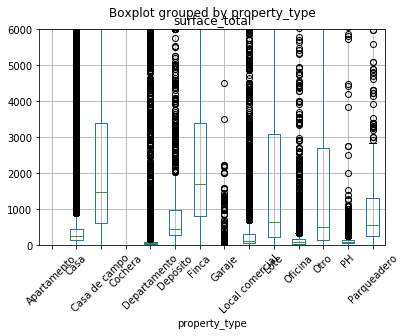

In [37]:
# Plot box plots of surface_total by property_type to determine appropriate actions
# The view is zoomed in to better see distributions
plt.sca(final_df.boxplot(column = 'surface_total', by = 'property_type'))
plt.ylim(0, 6000)
plt.xticks(rotation = 45)

The boxplot above shows significant differences in the distribution of surface_total (property area in square meters) across the various property types. Properties like cottages, farms, lots, and other have the largest areas while houses, apartments, and offices tend to have less, with warehouses and parking lots somewhere in between. This is completely reasonable to expect, and indicates that property type may be an effective grouping used to impute missing values. An exploration of other attributes and imputation options follows.

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 14 Text xticklabel objects>)

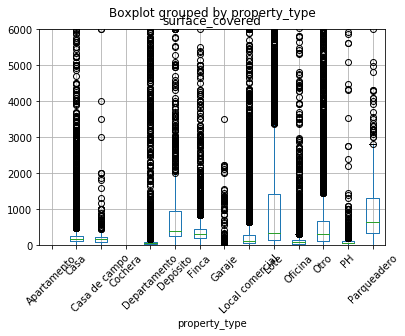

In [38]:
# Plot box plots of surface_covered by property_type to determine appropriate actions
plt.sca(final_df.boxplot(column = 'surface_covered', by = 'property_type'))
plt.ylim(0, 6000)
plt.xticks(rotation = 45)

The boxplot above shows the distribution of total covered area (area of house and covered structures in square meters) of properties by property type.  As expected, warehouses and parking lots have higher covered areas than other property types. A surprising feature of this vizualization is that land plots (lote) also have higher covered areas. This wasn't expected, since lots were thought of as empty land. This could be due to lower living standards in South America, where many people live on plots of land with covered structures built on them which don't quite count as houses.

Note that this plot is zoomed in to better show distributional differences. One striking feature is the large number of outliers present in the surface_covered and surface_total attributes.  These outliers are likely the result of wealth disparities in South America.

In [39]:
# Found some negative values in surface covered and surface total when trying to plot histogram
# remove these observations since they are errors.
final_df = final_df[final_df.surface_covered >= 0]
final_df = final_df[final_df.surface_total >= 0]

(array([1, 2, 3, 4, 5]), <a list of 5 Text xticklabel objects>)

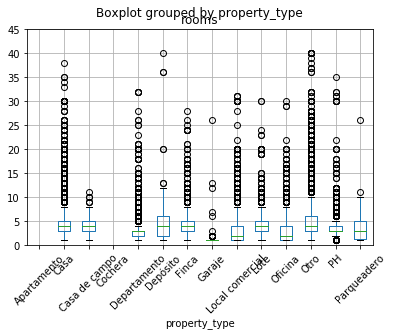

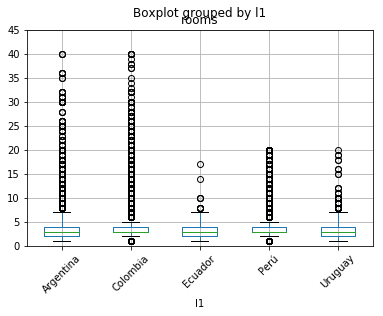

In [40]:
# Visualize distributions for rooms, bedrooms, bathrooms to determine appropriate imputation
# Plot box plots of rooms by property_type to determine appropriate actions
plt.sca(final_df.boxplot(column = 'rooms', by = 'property_type'))
plt.ylim(0, 45)
plt.xticks(rotation = 45)

# Plot box plots of rooms by country to determine appropriate actions
plt.sca(final_df.boxplot(column = 'rooms', by = 'l1'))
plt.ylim(0, 45)
plt.xticks(rotation = 45)

The above box plots show that room distributions are similar across countries, with most variation occurring as a result of the property type. Property type will be considered to impute the median room value to observations with missing rooms.

(array([1, 2, 3, 4, 5]), <a list of 5 Text xticklabel objects>)

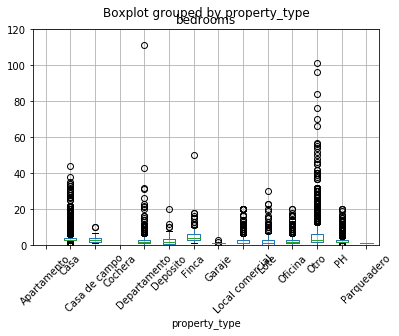

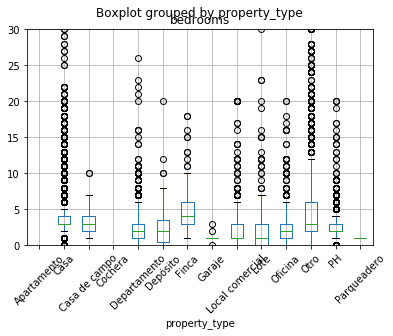

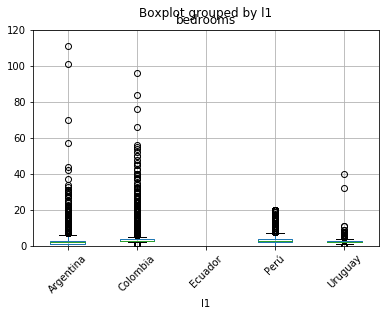

In [41]:
# Plot box plots of bedrooms by property_type to determine appropriate actions
plt.sca(final_df.boxplot(column = 'bedrooms', by = 'property_type'))
plt.ylim(0, 120)
plt.xticks(rotation = 45)

# Plot zoomed in box plots of bedrooms by property_type to show distributions
plt.sca(final_df.boxplot(column = 'bedrooms', by = 'property_type'))
plt.ylim(0, 30)
plt.xticks(rotation = 45)

# Plot box plots of rooms by country to determine appropriate actions
plt.sca(final_df.boxplot(column = 'bedrooms', by = 'l1'))
plt.ylim(0, 120)
plt.xticks(rotation = 45)

The box plots above show bedroom distribution differences by country and property type.  Again it was found that most of the variation is explained by property type.  Property type will be considered to impute median values to observations with missing bedroom values.  There are a significant number of outliers present in the data.  This is likely due to the large wealth disparity in South America.

(array([1, 2, 3, 4, 5]), <a list of 5 Text xticklabel objects>)

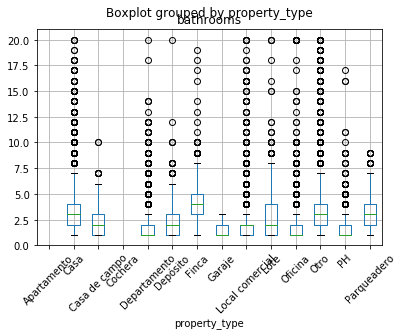

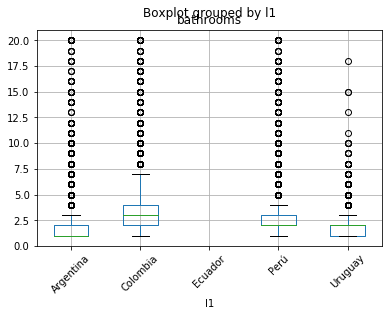

In [42]:
# Plot box plots of rooms by property_type to determine appropriate actions
plt.sca(final_df.boxplot(column = 'bathrooms', by = 'property_type'))
plt.ylim(0, 21)
plt.xticks(rotation = 45)

# Plot box plots of rooms by country to determine appropriate actions
plt.sca(final_df.boxplot(column = 'bathrooms', by = 'l1'))
plt.ylim(0, 21)
plt.xticks(rotation = 45)

The bathroom attribute has distributional differences both by country and property type, though property type appears to account for more variation than country.  Property type will be considered to impute missing values by median. Next we will explore the distributional differences for these attributes when grouped by both country and property type.

Certain geographical, cultural, and legal conditions within each country could cause variations in the number, types, and attributes of properties that exist within different countries.  Let's view medians by country and property type.

In [46]:
# Get median by country and property type
df_grouped = final_df.groupby(by=['l1','property_type'])
print (df_grouped.describe())

                          bathrooms                                           \
                              count      mean       std  min  25%  50%   75%   
l1        property_type                                                        
Argentina Casa              79241.0  2.385306  1.246640  1.0  1.0  2.0   3.0   
          Casa de campo       770.0  2.137662  1.178154  1.0  1.0  2.0   3.0   
          Departamento     161285.0  1.383712  0.717708  1.0  1.0  1.0   2.0   
          Depósito            319.0  2.056426  1.339981  1.0  1.0  2.0   3.0   
          Garaje               80.0  1.300000  0.513119  1.0  1.0  1.0   2.0   
          Local comercial    6225.0  1.785221  1.320921  1.0  1.0  1.0   2.0   
          Lote                753.0  2.160691  1.643636  1.0  1.0  2.0   3.0   
          Oficina            5765.0  1.916392  1.723903  1.0  1.0  1.0   2.0   
          Otro               1787.0  2.633464  2.633759  1.0  1.0  2.0   3.0   
          PH                19098.0  1.4

The table above shows the median bathrooms, bedrooms, rooms, surface_covered, surface_total, and more by country. These median values will be used to impute missing values in our data. It is believed that this method will impute the most accurate values to the dataset based on the differing conditions in each country and property types.

In [47]:
# Now use this grouping to fill the data set in each group, then transform back
df_imputed = df_grouped.transform(lambda grp: grp.fillna(grp.median()))
df_imputed[['id', 'start_date', 'end_date', 'created_on', 'property_type', 'l1', 'l2', 'l3', 'price', 'lat', 'lon', 'title', 'description']] = final_df[['id', 'start_date', 'end_date', 'created_on', 'property_type', 'l1', 'l2', 'l3', 'price', 'lat', 'lon', 'title', 'description']]

#df_imputed = df_imputed.transform(lambda grp: grp.fillna(0))
print (df_imputed.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 463724 entries, 0 to 463724
Data columns (total 18 columns):
lat                409211 non-null float64
lon                409211 non-null float64
rooms              463695 non-null float64
bedrooms           463465 non-null float64
bathrooms          463504 non-null float64
surface_total      463724 non-null float64
surface_covered    463724 non-null float64
price              463724 non-null float64
id                 463724 non-null object
start_date         463724 non-null datetime64[ns]
end_date           463724 non-null datetime64[ns]
created_on         463724 non-null datetime64[ns]
property_type      463724 non-null category
l1                 463724 non-null object
l2                 463724 non-null object
l3                 441217 non-null object
title              463724 non-null object
description        463724 non-null object
dtypes: category(1), datetime64[ns](3), float64(8), object(6)
memory usage: 64.1+ MB
None


The above table shows that the imputation was nearly a success. There are still a few observations with missing rooms, bedrooms, and bathrooms. These observations had country, property_type pairs that did not exist elsewhere in the dataset. They will be imputed by overall median later.

In [49]:
# Create categorical price variable
# price will be stratified as low, average, high for each property type
# Create quantile distribution
quantile = [.33, .66, 1]

# Get price ranges for each property type
df_quantiles.price.quantile(quantile)

property_type        
Apartamento      0.33             NaN
                 0.66             NaN
                 1.00             NaN
Casa             0.33    1.375000e+05
                 0.66    2.919107e+05
                 1.00    4.213251e+07
Casa de campo    0.33    1.350000e+05
                 0.66    2.300000e+05
                 1.00    4.800000e+06
Cochera          0.33             NaN
                 0.66             NaN
                 1.00             NaN
Departamento     0.33    9.500000e+04
                 0.66    1.700000e+05
                 1.00    4.747919e+07
Depósito         0.33    2.500000e+05
                 0.66    5.870000e+05
                 1.00    2.000000e+07
Finca            0.33    1.888161e+05
                 0.66    3.585657e+05
                 1.00    8.671281e+06
Garaje           0.33    1.700000e+04
                 0.66    2.300000e+04
                 1.00    3.000000e+06
Local comercial  0.33    1.200000e+05
                 0.66    3.3

In [50]:
# Get property type from index
quants = df_quantiles.price.quantile(quantile)

In [51]:
# Create a dataframe that stores price quantile information
quant_df = pd.DataFrame([quants])

In [53]:
# Reset indices to prevent error
df_imputed = df_imputed.reset_index(drop = True)

In [54]:
# Create the categorized price attribute manually
price_class = []
for obs in range(len(df_imputed)):
    if (df_imputed.property_type[obs] == 'Casa') & (df_imputed.property_type[obs] != 'Casa de campo'):
        if df_imputed.price[obs] < quant_df['Casa', 0.33][0]:
            price_class.append('Low')
        elif df_imputed.price[obs] >= quant_df['Casa', 0.66][0]:
            price_class.append('High')
        else:
            price_class.append('Average')
        
    elif (df_imputed.property_type[obs] == 'Casa de campo') & (df_imputed.property_type[obs] != 'Casa'):
        if df_imputed.price[obs] < quant_df['Casa de campo', 0.33][0]:
            price_class.append('Low')
        elif df_imputed.price[obs] >= quant_df['Casa de campo', 0.66][0]:
            price_class.append('High')
        else:
            price_class.append('Average')
            
    elif df_imputed.property_type[obs] == 'Departamento':
        if df_imputed.price[obs] < quant_df['Departamento', 0.33][0]:
            price_class.append('Low')
        elif df_imputed.price[obs] >= quant_df['Departamento', 0.66][0]:
            price_class.append('High')
        else:
            price_class.append('Average')
            
    elif df_imputed.property_type[obs] == 'Depósito':
        if df_imputed.price[obs] < quant_df['Depósito', 0.33][0]:
            price_class.append('Low')
        elif df_imputed.price[obs] >= quant_df['Depósito', 0.66][0]:
            price_class.append('High')
        else:
            price_class.append('Average')
            
    elif df_imputed.property_type[obs] == 'Garaje':
        if df_imputed.price[obs] < quant_df['Garaje', 0.33][0]:
            price_class.append('Low')
        elif df_imputed.price[obs] >= quant_df['Garaje', 0.66][0]:
            price_class.append('High')
        else:
            price_class.append('Average')
            
    elif df_imputed.property_type[obs] == 'Local comercial':
        if df_imputed.price[obs] < quant_df['Local comercial', 0.33][0]:
            price_class.append('Low')
        elif df_imputed.price[obs] >= quant_df['Local comercial', 0.66][0]:
            price_class.append('High')
        else:
            price_class.append('Average')

    elif df_imputed.property_type[obs] == 'Lote':
        if df_imputed.price[obs] < quant_df['Lote', 0.33][0]:
            price_class.append('Low')
        elif df_imputed.price[obs] >= quant_df['Lote', 0.66][0]:
            price_class.append('High')
        else:
            price_class.append('Average')
            
    elif df_imputed.property_type[obs] == 'Oficina':
        if df_imputed.price[obs] < quant_df['Oficina', 0.33][0]:
            price_class.append('Low')
        elif df_imputed.price[obs] >= quant_df['Oficina', 0.66][0]:
            price_class.append('High')
        else:
            price_class.append('Average')
            
    elif df_imputed.property_type[obs] == 'Otro':
        if df_imputed.price[obs] < quant_df['Otro', 0.33][0]:
            price_class.append('Low')
        elif df_imputed.price[obs] >= quant_df['Otro', 0.66][0]:
            price_class.append('High')
        else:
            price_class.append('Average')
            
    elif df_imputed.property_type[obs] == 'PH':
        if df_imputed.price[obs] < quant_df['PH', 0.33][0]:
            price_class.append('Low')
        elif df_imputed.price[obs] >= quant_df['PH', 0.66][0]:
            price_class.append('High')
        else:
            price_class.append('Average')

    elif (df_imputed.property_type[obs] == 'Finca'):
        if df_imputed.price[obs] < quant_df['Finca', 0.33][0]:
            price_class.append('Low')
        elif df_imputed.price[obs] >= quant_df['Finca', 0.66][0]:
            price_class.append('High')
        else:
            price_class.append('Average')
            
    elif (df_imputed.property_type[obs] == 'Parqueadero'):
        if df_imputed.price[obs] < quant_df['Parqueadero', 0.33][0]:
            price_class.append('Low')
        elif df_imputed.price[obs] >= quant_df['Parqueadero', 0.66][0]:
            price_class.append('High')
        else:
            price_class.append('Average')
print(len(price_class))

463724


In [55]:
# Add the new column to the imputed dataframe
df_imputed['price_class'] = pd.DataFrame(price_class)

# Print the data to confirm the price_class variable was added
df_imputed

,lat,lon,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,id,start_date,end_date,created_on,property_type,l1,l2,l3,title,description,price_class
0,NaN,NaN,4.0,3.0,2.0,198.0,150.0,385000.0,EWeY8jVhb8ielLeKtfibVw==,2019-09-15,2020-01-20,2019-09-15,Casa,Argentina,Bs.As. G.B.A. Zona Norte,Tigre,"Venta. Casa en una planta, 4 amb. con galería ...",MAM.(2) Hermosa propiedad en Barrio San Franci...,High
1,NaN,NaN,4.0,3.0,2.0,198.0,150.0,385000.0,IrEeG8ewIcfLVGSb14kH1w==,2019-09-15,2020-01-20,2019-09-15,Casa,Argentina,Bs.As. G.B.A. Zona Norte,Tigre,Venta. Casa en una planta.Lote interno. Barrio...,MAM. Hermosa propiedad en Barrio San Francisco...,High
2,-27.371199,-55.898454,7.0,3.0,2.0,173.0,173.0,195000.0,hPuiyAjuBI92uEQdFoY4Fw==,2019-09-15,1970-01-01,2019-09-15,Casa,Argentina,Misiones,Posadas,Casa - Posadas,Inmueble centrico ideal para Local comercial ...,Average
3,NaN,NaN,3.0,3.0,1.0,49.0,40.0,85000.0,9vIWv494LqC6crAkfpLeDg==,2019-09-15,2020-03-03,2019-09-15,Casa,Argentina,Santa Fe,Rosario,Cabaña en la Isla sobre riacho Los Marinos - V...,Lote de 20 metros de frente por 130 metros de ...,Low
4,-32.951146,-60.571979,3.0,3.0,1.0,49.0,40.0,85000.0,aydrtgoZ/frzXDcV20McuA==,2019-09-15,2020-03-03,2019-09-15,Casa,Argentina,Entre Ríos,Victoria,Cabaña en la Isla sobre riacho Los Marinos - V...,Lote de 20 metros de frente por 130 metros de ...,Low
5,-32.961060,-68.877991,4.0,3.0,3.0,400.0,400.0,570000.0,pcyMin/DYA9uU5PxtC+19w==,2019-09-15,2020-04-07,2019-09-15,Casa,Argentina,Mendoza,Luján de Cuyo,Casa a Estrenar 4 Habitaciones - Diseño y Term...,WONDER VENDE Espectacular Casa a ESTRENAR de D...,High
6,-34.572445,-58.420624,4.0,2.0,3.0,193.0,175.0,935000.0,/F4YPH2nVSaoiyunrdNBEQ==,2019-09-15,1970-01-01,2019-09-15,Departamento,Argentina,Capital Federal,Palermo,Departamento - Palermo,TORRE PREMIUM PANEDILLE del estudio del Premia...,High
7,-34.578547,-58.430038,2.0,2.0,1.0,31.0,31.0,89000.0,wb722Ak53RN+qPDHNnNiLw==,2019-09-15,1970-01-01,2019-09-15,Departamento,Argentina,Capital Federal,Palermo,Departamento venta,Es un departamento de 2 ambientes interno pero...,Low
8,-34.586423,-58.414190,2.0,2.0,1.0,32.0,32.0,132900.0,CWhyNLsxy+1ixo/cDUN1Dg==,2019-09-15,1970-01-01,2019-09-15,Departamento,Argentina,Capital Federal,Palermo,Venta - Departamento 2 Amb. - Palermo,Hermoso departamento de dos ambientes en Paler...,Average
9,-34.584758,-58.413319,3.0,2.0,1.0,88.0,88.0,230000.0,OtiAJtGJ6lH88FtDpGYhgw==,2019-09-15,2019-09-25,2019-09-15,Departamento,Argentina,Capital Federal,Palermo,Departamento - Palermo,"Palermo, 3 amb, 88m, Beruti 3700 p2, u$s 230.0...",High


In [56]:
# Check for missing values. These did not have corresponding country, property_type paired medians.
df_imputed.isna().sum()

lat                54513
lon                54513
rooms                 29
bedrooms             259
bathrooms            220
surface_total          0
surface_covered        0
price                  0
id                     0
start_date             0
end_date               0
created_on             0
property_type          0
l1                     0
l2                     0
l3                 22507
title                  0
description            0
price_class            0
dtype: int64

The table above shows observations missing rooms, bedrooms, and bathrooms. These will now be imputed with the overall median by property type.

In [57]:
# Fill remaining missing rooms, bedrooms, and bathrooms by overall median by property_type
df_grouped = final_df.groupby(by='property_type')
df_imputed2 = df_grouped.transform(lambda grp: grp.fillna(grp.median()))
df_imputed2[['id', 'start_date', 'end_date', 'created_on', 'property_type', 'l1', 'l2', 'l3', 'price', 'lat', 'lon', 'title', 'description', 'price_class']] = df_imputed[['id', 'start_date', 'end_date', 'created_on', 'property_type', 'l1', 'l2', 'l3', 'price', 'lat', 'lon', 'title', 'description', 'price_class']]

In [59]:
## Export to csv before dummifying
#df_imputed2.to_csv("Imputed_Dataset.csv", sep = ',')

The following dataset is the *Final* dataset to be used for analysis. It has 19 attributes and 463,724 observations. It will require one-hot encoding for classification later.

In [61]:
# Print the final dataset
df_imputed2

,id,start_date,end_date,created_on,lat,lon,l1,l2,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,title,description,property_type,price_class
0,EWeY8jVhb8ielLeKtfibVw==,2019-09-15,2020-01-20,2019-09-15,NaN,NaN,Argentina,Bs.As. G.B.A. Zona Norte,Tigre,4.0,3.0,2.0,198.0,150.0,385000.0,"Venta. Casa en una planta, 4 amb. con galería ...",MAM.(2) Hermosa propiedad en Barrio San Franci...,Casa,High
1,IrEeG8ewIcfLVGSb14kH1w==,2019-09-15,2020-01-20,2019-09-15,NaN,NaN,Argentina,Bs.As. G.B.A. Zona Norte,Tigre,4.0,3.0,2.0,198.0,150.0,385000.0,Venta. Casa en una planta.Lote interno. Barrio...,MAM. Hermosa propiedad en Barrio San Francisco...,Casa,High
2,hPuiyAjuBI92uEQdFoY4Fw==,2019-09-15,1970-01-01,2019-09-15,-27.371199,-55.898454,Argentina,Misiones,Posadas,7.0,3.0,2.0,173.0,173.0,195000.0,Casa - Posadas,Inmueble centrico ideal para Local comercial ...,Casa,Average
3,9vIWv494LqC6crAkfpLeDg==,2019-09-15,2020-03-03,2019-09-15,NaN,NaN,Argentina,Santa Fe,Rosario,3.0,3.0,1.0,49.0,40.0,85000.0,Cabaña en la Isla sobre riacho Los Marinos - V...,Lote de 20 metros de frente por 130 metros de ...,Casa,Low
4,aydrtgoZ/frzXDcV20McuA==,2019-09-15,2020-03-03,2019-09-15,-32.951146,-60.571979,Argentina,Entre Ríos,Victoria,3.0,3.0,1.0,49.0,40.0,85000.0,Cabaña en la Isla sobre riacho Los Marinos - V...,Lote de 20 metros de frente por 130 metros de ...,Casa,Low
5,pcyMin/DYA9uU5PxtC+19w==,2019-09-15,2020-04-07,2019-09-15,-32.961060,-68.877991,Argentina,Mendoza,Luján de Cuyo,4.0,3.0,3.0,400.0,400.0,570000.0,Casa a Estrenar 4 Habitaciones - Diseño y Term...,WONDER VENDE Espectacular Casa a ESTRENAR de D...,Casa,High
6,/F4YPH2nVSaoiyunrdNBEQ==,2019-09-15,1970-01-01,2019-09-15,-34.572445,-58.420624,Argentina,Capital Federal,Palermo,4.0,2.0,3.0,193.0,175.0,935000.0,Departamento - Palermo,TORRE PREMIUM PANEDILLE del estudio del Premia...,Departamento,High
7,wb722Ak53RN+qPDHNnNiLw==,2019-09-15,1970-01-01,2019-09-15,-34.578547,-58.430038,Argentina,Capital Federal,Palermo,2.0,2.0,1.0,31.0,31.0,89000.0,Departamento venta,Es un departamento de 2 ambientes interno pero...,Departamento,Low
8,CWhyNLsxy+1ixo/cDUN1Dg==,2019-09-15,1970-01-01,2019-09-15,-34.586423,-58.414190,Argentina,Capital Federal,Palermo,2.0,2.0,1.0,32.0,32.0,132900.0,Venta - Departamento 2 Amb. - Palermo,Hermoso departamento de dos ambientes en Paler...,Departamento,Average
9,OtiAJtGJ6lH88FtDpGYhgw==,2019-09-15,2019-09-25,2019-09-15,-34.584758,-58.413319,Argentina,Capital Federal,Palermo,3.0,2.0,1.0,88.0,88.0,230000.0,Departamento - Palermo,"Palermo, 3 amb, 88m, Beruti 3700 p2, u$s 230.0...",Departamento,High


In [ ]:
## Import dataset from csv
#df_imputed2 = pd.read_csv('C:\\Users\\Tpeng\\OneDrive\\Documents\\SMU\\Term 3\\Machine Learning\\Lab1\\Imputed_Dataset.csv', sep = ',', header = 0)

In [62]:
# Reformat attributes
ordinal_vars = ['rooms', 'bedrooms', 'bathrooms' ]
continuous_vars = ['lat', 'lon', 'surface_total', 'surface_covered', 'price']
categorical_vars = ['l1', 'l2', 'l3', 'property_type', 'price_class']
string_vars = ['id', 'title', 'description']
time_vars = ['start_date', 'end_date', 'created_on']

# Change data types
df_imputed2[ordinal_vars] = df_imputed2[ordinal_vars].astype(np.int64)
df_imputed2[continuous_vars] = df_imputed2[continuous_vars].astype(np.float64)
df_imputed2[categorical_vars] = df_imputed2[categorical_vars].astype('category')
df_imputed2[string_vars] = df_imputed2[string_vars].astype(str)

# Show dataset properties
df_imputed2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 463724 entries, 0 to 463724
Data columns (total 19 columns):
id                 463724 non-null object
start_date         463723 non-null datetime64[ns]
end_date           463723 non-null datetime64[ns]
created_on         463723 non-null datetime64[ns]
lat                409210 non-null float64
lon                409210 non-null float64
l1                 463723 non-null category
l2                 463723 non-null category
l3                 441216 non-null category
rooms              463724 non-null int64
bedrooms           463724 non-null int64
bathrooms          463724 non-null int64
surface_total      463724 non-null float64
surface_covered    463724 non-null float64
price              463723 non-null float64
title              463724 non-null object
description        463724 non-null object
property_type      463723 non-null category
price_class        463723 non-null category
dtypes: category(5), datetime64[ns](3), float64(5), int

The table above shows the final dataset and information regarding attribute types. There are 19 attributes and 463,724 observations.

## 3. Give appropriate statistics of the most important attributes in data
The most important attributes in the dataset related to real estate pricing include the number of rooms, bedrooms, bathrooms, surface_total, surface_covered, country (l1), and property type (property_type).

In [63]:
df_imputed2.describe()

,lat,lon,rooms,bedrooms,bathrooms,surface_total,surface_covered,price
count,409210.000000,409210.000000,463724.000000,463724.000000,463724.000000,463724.000000,4.637240e+05,4.637230e+05
mean,-22.668973,-64.314794,3.250369,2.361879,2.101673,661.221067,6.747074e+02,2.678242e+05
std,17.716000,7.847229,1.712051,1.268406,1.345292,5333.413901,1.438690e+05,6.241050e+05
min,-54.834711,-81.731010,1.000000,0.000000,1.000000,10.000000,0.000000e+00,3.828151e+03
25%,-34.608767,-74.061000,2.000000,2.000000,1.000000,59.000000,5.400000e+01,8.900000e+04
50%,-34.490918,-58.658175,3.000000,2.000000,2.000000,100.000000,9.100000e+01,1.500000e+05
75%,3.359000,-58.431278,4.000000,3.000000,3.000000,230.000000,1.800000e+02,2.764642e+05
max,13.374803,-53.391475,40.000000,111.000000,20.000000,500000.000000,9.107250e+07,4.787449e+07


The above table shows descriptive statistics for the numeric attributes of our dataset. A significant finding in this table is the high standard deviation with respect to the surface_total, surface_covered, and price attributes. While this is not ideal for model building, this is likely due to the wide range of differences between the many property types. It is likely that when property type is considered in our models, the high standard deviation will be significantly reduced.

In [64]:
df_imputed2.groupby(by = 'property_type').describe()

bathrooms                                                \
                    count      mean       std  min  25%  50%  75%   max   
property_type                                                             
Apartamento           0.0       NaN       NaN  NaN  NaN  NaN  NaN   NaN   
Casa             131891.0  2.747723  1.484131  1.0  2.0  3.0  3.0  20.0   
Casa de campo       854.0  1.921546  1.166021  1.0  1.0  2.0  2.0  10.0   
Cochera               0.0       NaN       NaN  NaN  NaN  NaN  NaN   NaN   
Departamento     246400.0  1.719286  1.001194  1.0  1.0  1.0  2.0  20.0   
Depósito           2546.0  2.037313  1.010253  1.0  2.0  2.0  2.0  16.0   
Finca              5229.0  3.913177  1.619541  1.0  3.0  4.0  5.0  18.0   
Garaje             2387.0  1.363636  0.921560  1.0  1.0  1.0  1.0  16.0   
Local comercial   14266.0  2.049348  1.371158  1.0  1.0  2.0  2.0  20.0   
Lote              12651.0  2.367797  1.240159  1.0  2.0  2.0  2.0  20.0   
Oficina           11566.0  1.835207  1.640176  1.0  1.0  1.0  2.0  20.0   
Otro              15059.0  3.074374  1.933973  1.0  2.0  3.0  3.0  20.0   
PH                20403.0  1.469931  0.812795  1.0  1.0  1.0  2.0  20.0   
Parqueadero         471.0  2.787686  1.549721  1.0  2.0  3.0  3.0   9.0   

                 bedrooms                                                 \
                    count      mean       std  min  25%  50%  75%    max   
property_type                                                              
Apartamento           0.0       NaN       NaN  NaN  NaN  NaN  NaN    NaN   
Casa             131891.0  3.139085  1.262471  0.0  3.0  3.0  3.0  111.0   
Casa de campo       854.0  2.694379  1.077987  1.0  2.0  3.0  3.0   10.0   
Cochera               0.0       NaN       NaN  NaN  NaN  NaN  NaN    NaN   
Departamento     246400.0  2.002999  0.825431  0.0  2.0  2.0  2.0   66.0   
Depósito           2546.0  2.066379  0.696830  0.0  2.0  2.0  2.0   16.0   
Finca              5229.0  3.714094  1.192264  1.0  3.0  4.0  4.0   42.0   
Garaje             2387.0  1.431923  1.381789  1.0  1.0  1.0  1.0   40.0   
Local comercial   14266.0  1.363942  0.967339  0.0  1.0  1.0  1.0   26.0   
Lote              12651.0  1.564382  1.681057  0.0  1.0  1.0  2.0   76.0   
Oficina           11566.0  2.138682  0.981434  0.0  2.0  2.0  2.0   30.0   
Otro              15059.0  3.096222  2.773439  0.0  3.0  3.0  3.0  101.0   
PH                20403.0  2.247366  1.044556  0.0  2.0  2.0  3.0   24.0   
Parqueadero         471.0  1.777070  1.228727  1.0  1.0  2.0  2.0   14.0   

                      lat                                              \
                    count       mean        std        min        25%   
property_type                                                           
Apartamento           0.0        NaN        NaN        NaN        NaN   
Casa             111264.0 -20.835506  18.410103 -54.834711 -34.605115   
Casa de campo       714.0 -33.897514   3.592933 -40.148693 -34.802505   
Cochera               0.0        NaN        NaN        NaN        NaN   
Departamento     221856.0 -24.149817  17.029964 -54.812682 -34.608248   
Depósito           2286.0 -32.430743   6.644693 -45.897574 -34.649096   
Finca              4220.0   5.200415   1.565802   1.149300   4.468720   
Garaje             2336.0 -34.324573   1.473130 -41.138485 -34.611445   
Local comercial   12833.0 -25.538203  15.651354 -53.783360 -34.611798   
Lote              11059.0  -9.023880  16.271571 -50.351289 -17.183421   
Oficina           10280.0 -24.441782  16.856953 -42.768980 -34.604946   
Otro              12793.0  -7.823312  18.466227 -48.748315 -34.378295   
PH                19194.0 -34.744971   1.169039 -46.591166 -34.652544   
Parqueadero         375.0   5.322051   1.964981   2.500120   4.597664   

                                                       lon             \
                       50%        75%        max     count       mean   
property_type                                              

The table above shows that the standard deviation for surface_covered and surface_total are indeed smaller for many property types than the overall value found above. However, the standard deviation of price across all property types is still much larger than anticipated or desired. This could be due to differences between the nations' geography, living conditions, and industries. The incorporation of other attributes may help lower the standard deviation in our models.

In [65]:
df_imputed2.groupby(by = 'l1').describe()

bathrooms                                                bedrooms  \
              count      mean       std  min  25%  50%  75%   max     count   
l1                                                                            
Argentina  300518.0  1.719085  1.057127  1.0  1.0  1.0  2.0  20.0  300518.0   
Colombia   125570.0  2.903990  1.495231  1.0  2.0  3.0  4.0  20.0  125570.0   
Ecuador       209.0  2.124402  1.001839  1.0  1.0  3.0  3.0   7.0     209.0   
Perú        28868.0  2.665304  1.644172  1.0  2.0  2.0  3.0  20.0   28868.0   
Uruguay      8558.0  1.862468  1.078605  1.0  1.0  2.0  2.0  18.0    8558.0   

                                                               lat             \
               mean       std  min  25%  50%  75%    max     count       mean   
l1                                                                              
Argentina  2.203861  1.080323  0.0  2.0  2.0  3.0  111.0  269080.0 -34.501658   
Colombia   2.777144  1.587074  1.0  2.0  3.0  3.0   96.0  105657.0   5.745212   
Ecuador    2.478469  0.665615  1.0  2.0  3.0  3.0    6.0     201.0  -0.982834   
Perú       2.209159  1.201077  0.0  2.0  2.0  3.0   20.0   26337.0 -12.250662   
Uruguay    2.329984  0.934211  0.0  2.0  2.0  3.0   28.0    7935.0 -34.888848   

                                                                            \
                std        min        25%        50%        75%        max   
l1                                                                           
Argentina  1.589233 -54.834711 -34.628968 -34.593562 -34.464566 -22.183331   
Colombia   2.240505   0.499576   4.623801   4.806000   6.244000  13.374803   
Ecuador    1.097548  -3.282575  -2.147129  -0.207472  -0.179599   0.327040   
Perú       2.007659 -18.293581 -12.149471 -12.096166 -12.046373  -3.497111   
Uruguay    0.122797 -34.972632 -34.927733 -34.907317 -34.889502 -30.917862   

                lon                                                        \
              count       mean       std        min        25%        50%   
l1                                                                          
Argentina  269080.0 -59.173593  2.164004 -72.299316 -58.690088 -58.466800   
Colombia   105657.0 -74.994523  1.081773 -81.731010 -75.670094 -75.297980   
Ecuador       201.0 -78.864452  0.658647 -80.859384 -79.013687 -78.483719   
Perú        26337.0 -76.497630  1.949302 -81.282165 -77.052926 -77.009854   
Uruguay      7935.0 -55.647191  0.706013 -58.417028 -56.164531 -56.078702   

                                    price                               \
                 75%        max     count           mean           std   
l1                                                                       
Argentina -58.410219 -53.647482  300518.0  252267.771582  4.331010e+05   
Colombia  -74.060000 -69.391816  125570.0  279265.924995  8.310993e+05   
Ecuador   -78.460744 -77.882460     209.0  294974.416268  6.361967e+05   
Perú      -76.940476 -69.175585   28868.0  362671.124765  1.109872e+06   
Uruguay   -54.943493 -53.391475    8558.0  325612.515908  4.185086e+05   

                                                                      \
                    min            25%            50%            75%   
l1                                                                     
Argentina   3828.151120   95000.000000  155000.000000  275000.000000   
Colombia    5020.673361   72432.275822  129589.632829  264900.227628   
Ecuador    13500.000000   89990.000000  138000.000000  225000.000000   
Perú        5000.000000   92000.000000  160000.000000  305000.000000   
Uruguay     5033.670034  138500.000000  210000.000000  350000.000000   

                            rooms                                          \
                    max     count      mean       std  min  25%  50%  75%   
l1                                                                          
Argentina  4.747919e+07  300518.0  3.125101  1.581755  1.0  2.0  3.0  4.0   
Colombia

After exploring price distribution by country, it was still found that housing prices have a large standard deviation. This could have a negative impact on our models performance, unless other attributes can reduce the deviation.

In [67]:
# Output statistics of categorical variables
print(df_imputed2.l1.value_counts())
print(df_imputed2.property_type.value_counts())

Argentina    300518
Colombia     125570
Perú          28868
Uruguay        8558
Ecuador         209
Name: l1, dtype: int64
Departamento       246400
Casa               131891
PH                  20403
Otro                15059
Local comercial     14266
Lote                12651
Oficina             11566
Finca                5229
Depósito             2546
Garaje               2387
Casa de campo         854
Parqueadero           471
Cochera                 0
Apartamento             0
Name: property_type, dtype: int64


There are thousands of observations for Argentina, Columbia, Peru, and Ururguay, while Ecuador only has about 200. This could potentially reduce the accuracy of the model regarding properties located in Ecuador, and potentially in Uruguay as well. When considering property type, we face the same issues with parking lots (Parqueadero), cottages (Casa de campo), and potentially garages (Garaje), warehouses (Deposito) and farms (Finca). This should be monitored when building our classification and regression models.

In [180]:
############################# DID NOT USE #################################
# Define Function for removing outliers of numeric columns 
def remove_outlier(df):
	    low = .05
	    high = .95
	    quant_df = df.quantile([low, high])
	    df = df[(df['price'] > quant_df.loc[low, 'price']) 
               & (df['price'] < quant_df.loc[high, 'price'])]
	    return df

In [181]:
# Remove bottom and top 5%
#final_df4 = remove_outlier(final_df3)
#final_df3 = final_df4

## 4. EDA: Visualize the most important attributes
The following section visually explores the data to gain insights into useful attributes.

In [ ]:
# Use Pandas-profiling for EDA and Display Inside the Jupyter Notebook
profile = ProfileReport(no_outdf, title='EDA for Home Data', explorative=True)
profile.to_notebook_iframe()

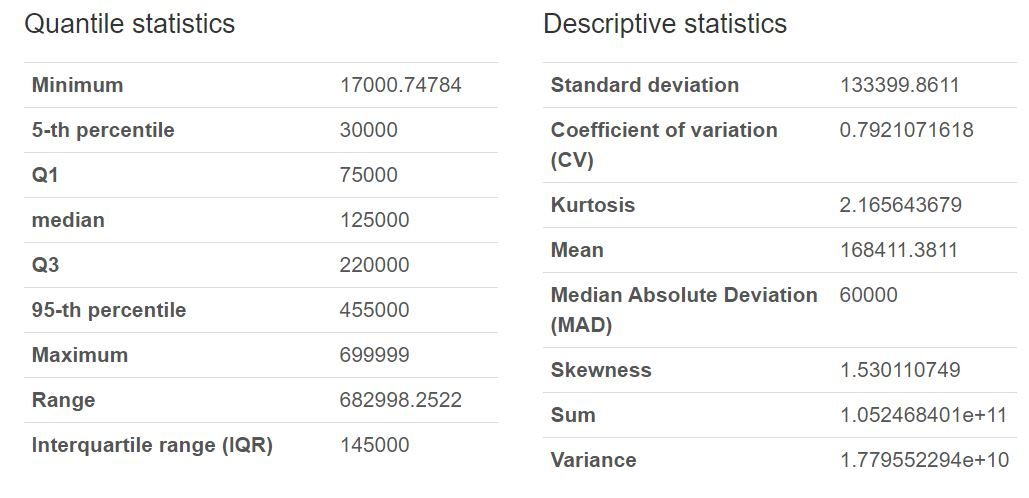

In [1]:
from IPython.display import Image
Image("price_dis.jpg")

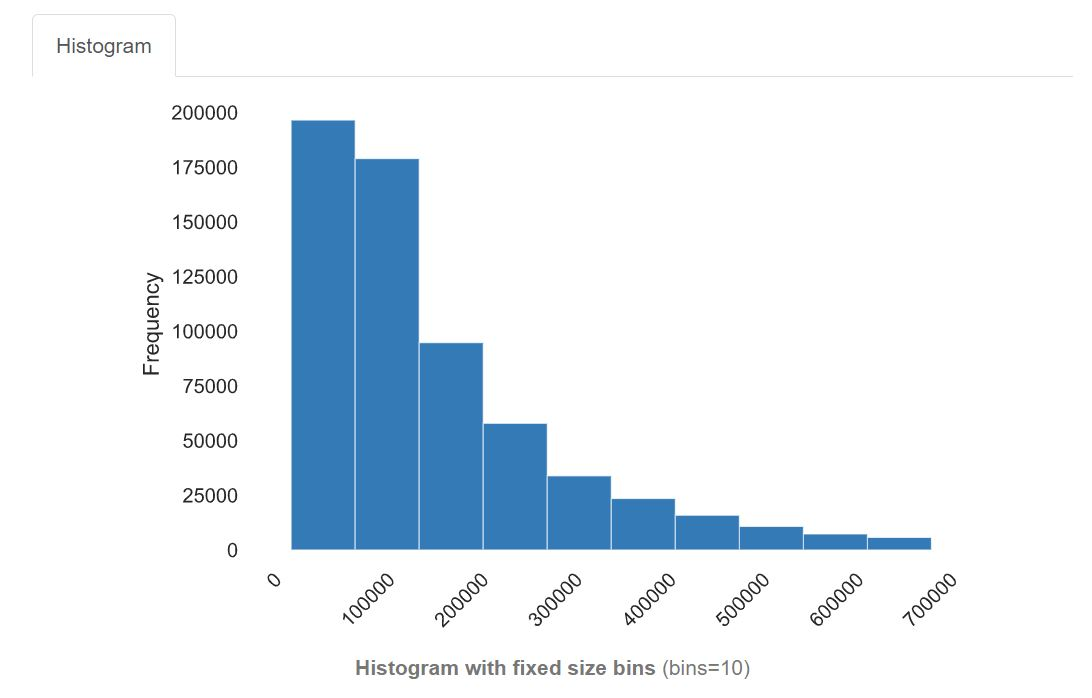

In [2]:
Image("price_histo.jpg")

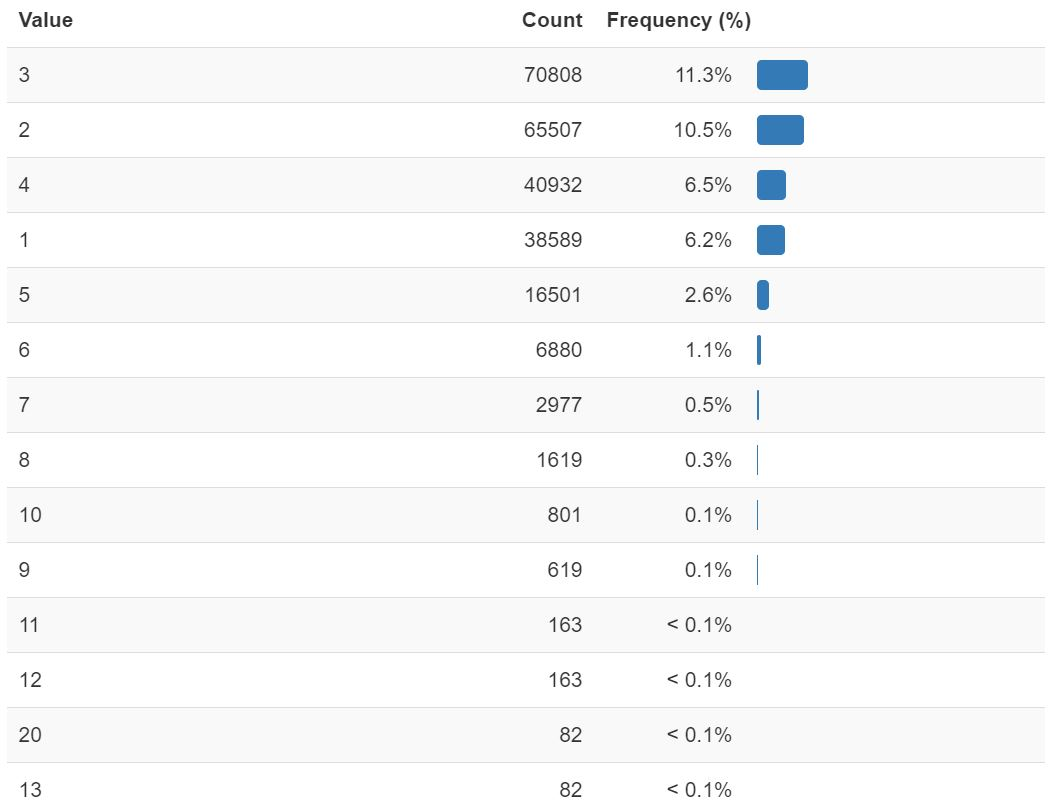

In [3]:
Image("rooms_freq.jpg")

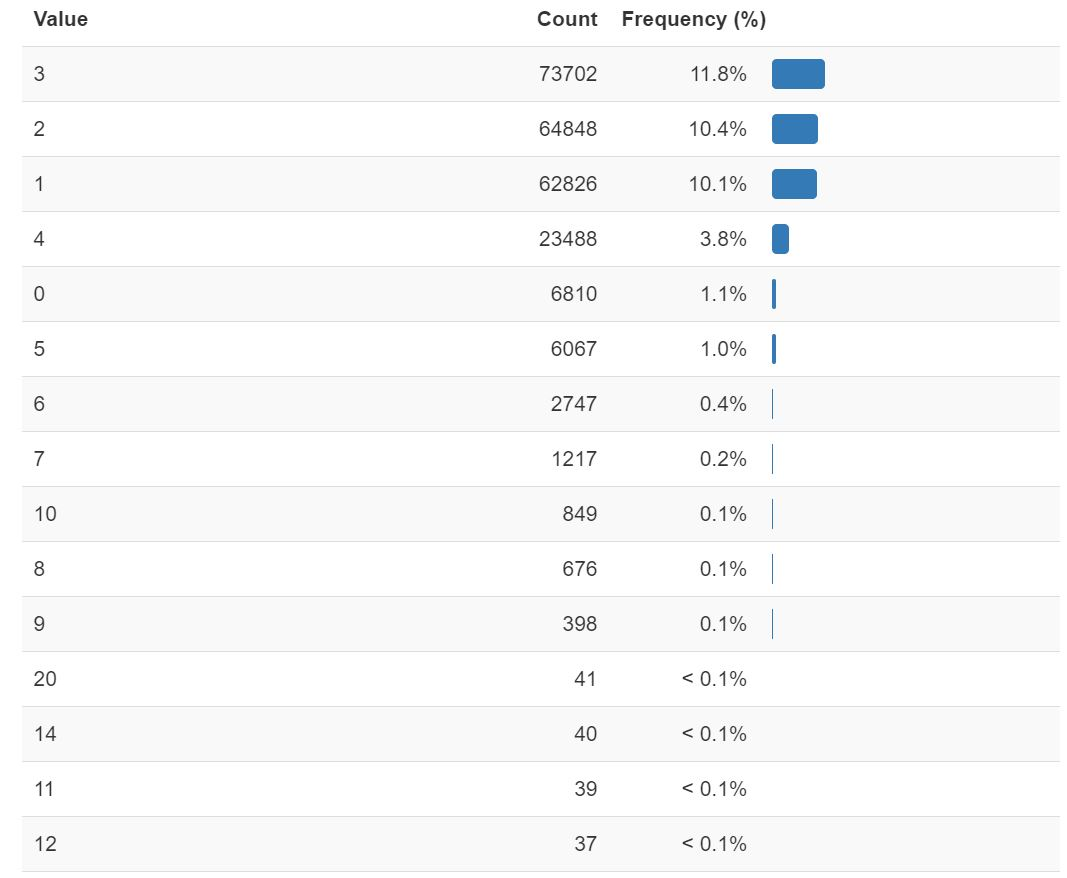

In [4]:
Image("bedrooms_freq.jpg")

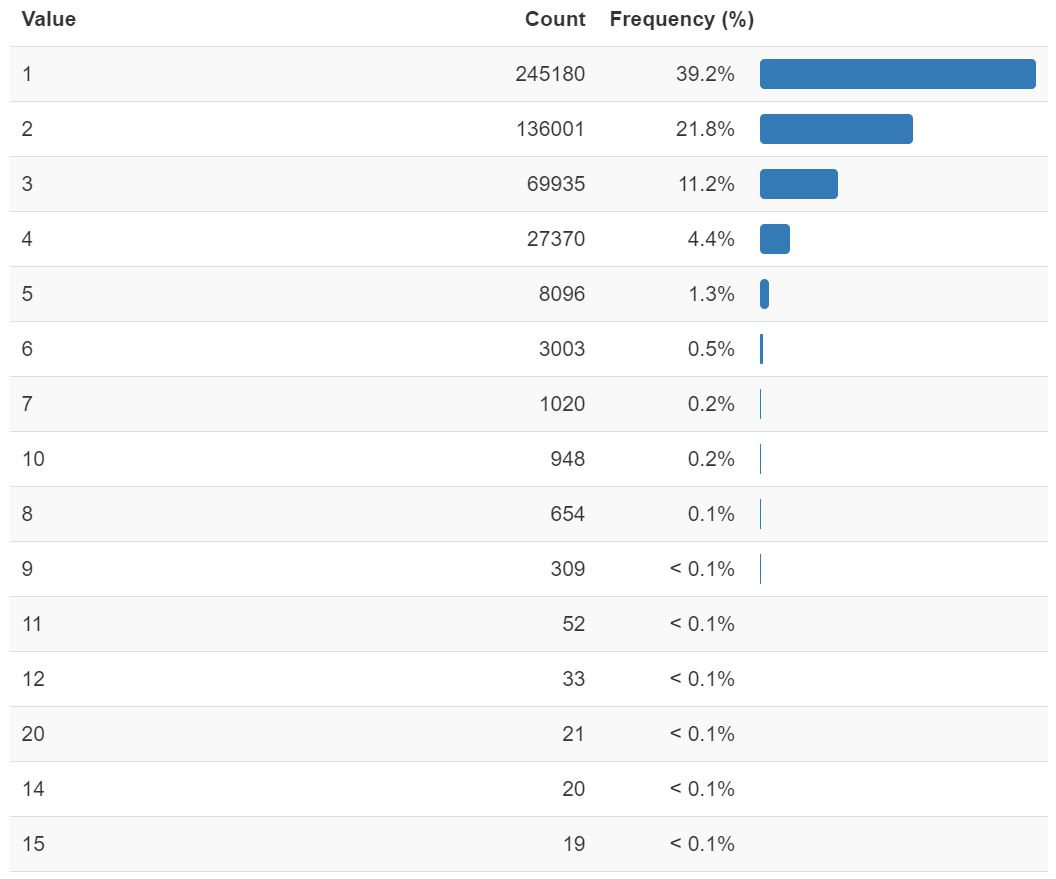

In [5]:
Image("bathrooms_freq.jpg")

## 5. Notable Attributes & Relationships for South American Real Estate Properties
There are contrasting economic performances and geopolitical factors affecting the relative desirability of real estates in the following South American countries.  The distribution of property prices differed between the countries.  This is likely due to a combination of several factors such as each country’s standard of living, GDP, physical environment (dense rainforests, mountainous terrain, plains, etc.), among others.  These differences are reflected in the price distribution by country.

(0, 800000)

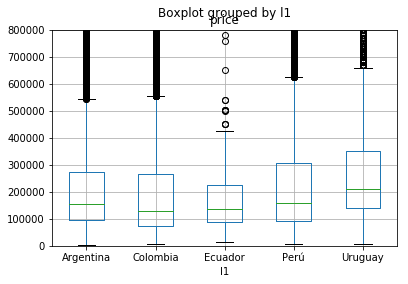

In [68]:
# Boxplots of price by country
plt.sca(df_imputed2.boxplot(column = 'price', by = 'l1'))
plt.ylim(0, 800000)

Argentina is in the middle of an economic recession currently.  This economic performance may be reflected in the relatively low price range seen and the median price of real estate properties denoted by the green bar. 

Brasil (Brazil) has a wide socioeconomic gap between the rich and poor which is beginning to narrow thanks to economic successes in the last 7 years.  This may explain the high median price for real estate and the wide range of pricing. 

Ecuador is relatively smaller in size and population than the other South American countries.  It has a very liberal attitude toward foreign ownership of real estates.  Demand is in close balance with supply, which explains the relatively narrower band of pricing and median close to the 2nd quartile range.

Peru notably has the longest range of pricing of all the countries below.  This wide range of real estate pricing may be the reflection of an emerging market that has enjoyed successes in the past few years.  Buyers are willing to spend top dollars in the push to diversify their portfolio for potential long term investments.  

Uruguay is the top choice among expatriates looking for political stability and a market economy characterized by high quality of living. Real estate pricing is relatively low due to a mature real estate market.  

Source: https://www.latincarib.com/south-american-real-estate/

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 14 Text xticklabel objects>)

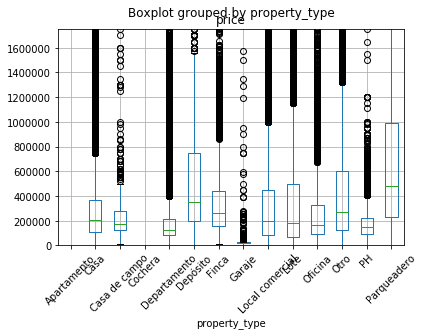

In [69]:
# Boxplots of price by property_type
plt.sca(df_imputed2.boxplot(column = 'price', by = 'property_type'))
plt.ylim(0, 1750000)
plt.xticks(rotation = 45)

One of the most apparent relationships is the distribution of price by property type.  This is to be expected, since different properties have different uses (commercial vs residential).  Commercial properties like warehouses, shops, and offices tend to be highly right-skewed, indicating higher prices, while residential-type properties tend to be much less right-skewed, indicating lower property values.

Residential types of real estate  include Casa/House, Casa de Campo/Cottage, Deparamento/Apartments, and PH/Condominiums and group housing.  Pricing for residential housing range from 150,000 to 750,000 dollars across all South American countries.  

Commercial types of real estate include Cochera/Garage, Deposito/Warehouse, Local Comercial/Shops, Lote/Empty lots, Officina/Office.  These tend to have higher pricing (except empty lots) ranging in the millions, especially warehouses,  due to size and commercial utility rather than country differences.

## 6. Explore Joint Attribute Relationships

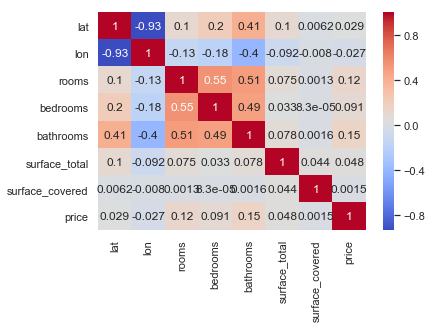

In [70]:
# Correlation heatmap
sns.set(style = 'darkgrid')
sns.heatmap(df_imputed2.corr(), cmap = 'coolwarm', annot = True)

It is expected that there would be a strong correlation between price, total rooms, number of bedrooms, bathrooms, total surface as measured by square meter, and total surface covered. Although these relationships do have positive correlations, there seem to be regional preferences (latitude) for the number of bedrooms and bathrooms as shown by the above correlation heatmap. 

C:\Users\Tpeng\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)
C:\Users\Tpeng\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\Users\Tpeng\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\Users\Tpeng\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * 

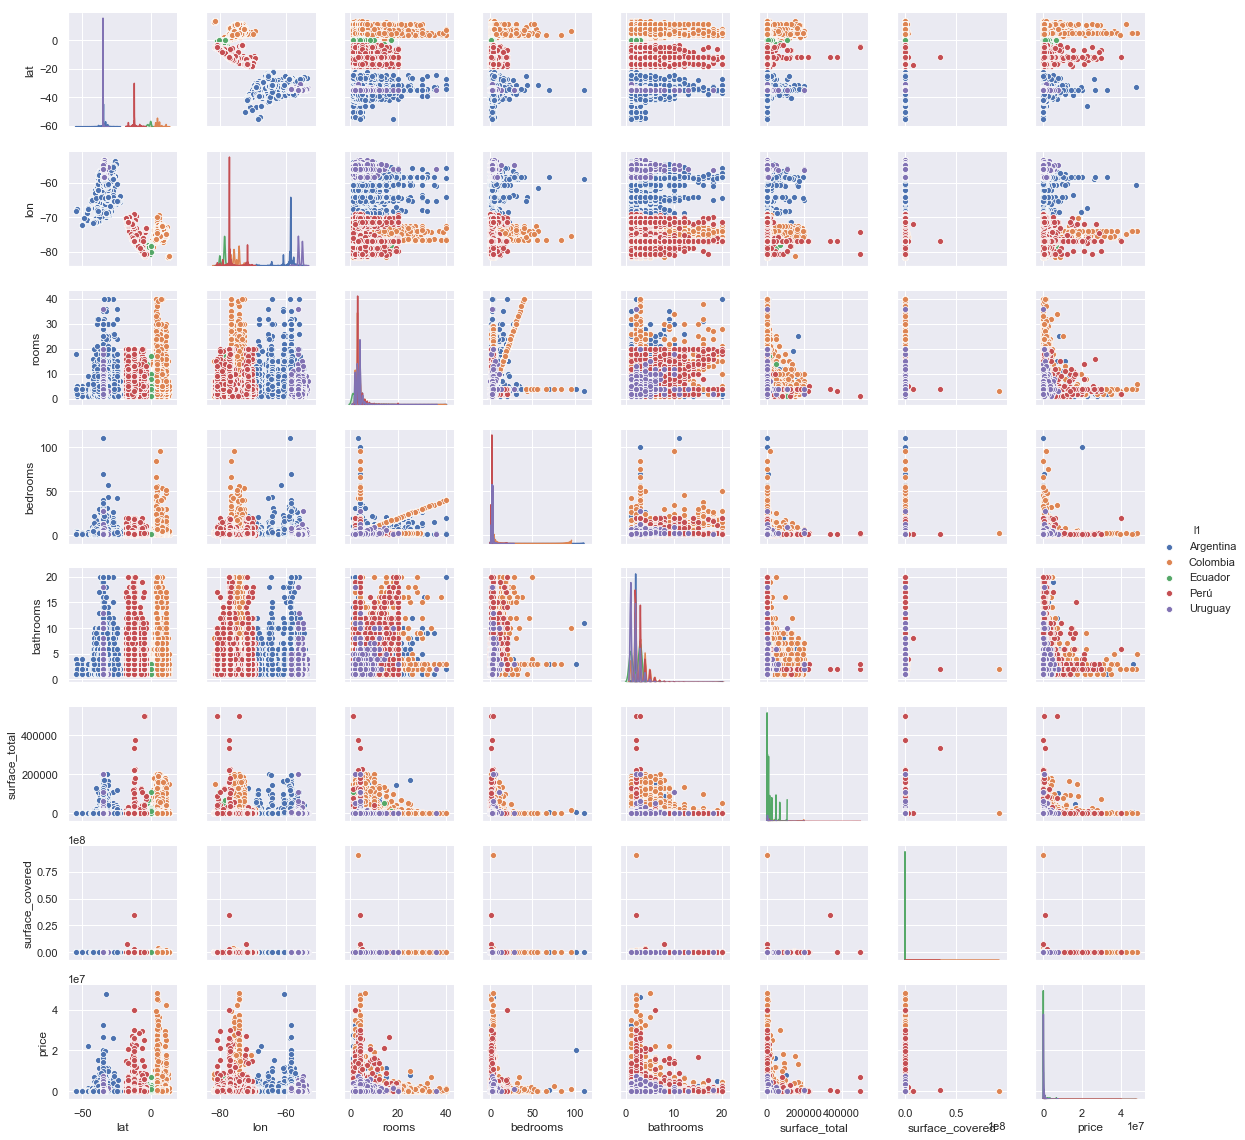

In [71]:
sns.pairplot(df_imputed2, hue= 'l1', size = 2)

## 7. Additional Features
There are two additional features that would enhance the utility of the existing data set.  
First, we added a currency feature as a lookup table and standardized all foreign currencies to US currencies for ease of comparability.  Thanks to its stability, the US dollar is often used as a global benchmark to compare relative monetary values. 

Secondly,  South America is bordered by the Atlantic Ocean to the east, the Pacific Ocean to the west and north, and by North America and the Caribbean Sea to the northeast.  The continent is also anchored by the Andes Mountain range, which affects the overall climate.  Features related to geographical locations like distances to mountains and beaches can be added to the data to illustrate regional preferences as reflected in pricing.  Visualizations generated from classification algorithms and visualized via geo polygons will help explain consumer preferences for real estates located in close proximity to vacation destinations.  Other features that could provide additional information are populations for each regional subdivision, distances to amenities, and more detailed information on properties such as construction date, number of floors, and condition.  
Reference: https://www.latincarib.com/south-american-real-estate/

In [6]:
# 3. Visualize the most important attributes appropriately (AT LEAST 5 ATTRIBUTES)
# Provide an interpretation for each chart
# Explain each attribute why the chosen visualization is appropriate


In [7]:
# 4. Explain relationships b/t attributes
# Scatterplots, correlations, cross-tabulation, group-wise averages, etc. as appropriate and explain interesting relationships.


In [8]:
# 5. Identify and explain interesting relationships b/t features and the class you are trying to predict (ie. rel b/t
# vars and the target classification)


In [9]:
# 6. Are there other features that could be added to the data or created from existing features? Which ones?


In [ ]:
########## Exceptional Work ##########

# Free reign to provide additional analyses
# Idea: implement dimensionality reduction, then visualize and interpret the results

# Other Ideas:

In [179]:
# Try PCA, though it is not recommended for categorical variables
#Y = final_df3['price']
#X = final_df3.drop(labels = 'price', axis = 1)